# Task 2: What Category Family Would Buy Next

# I. Imports

In [921]:
# importing necessary Python libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
#import plotly.figure_factory as ff

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

# II. Functions

In [922]:
# Measuring results
def metrics(y_test, probs, y_pred_test):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Model ROC AUC = %0.5f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    f1_test_n = f1_score(y_test, y_pred_test)
    print('f1 score:=',round(f1_test_n,4))

    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    print('precision: {:.4f}\nrecall: {:.4f}'.format(precision, recall))

#     calc_accuracy(y_test, y_pred_test)
#     acc, TP, TN, P, N = calc_accuracy(y_test, y_pred_test)
#     print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {:.4f}'.format(TP, TN, P, N, acc))

    conf_mat = confusion_matrix(y_test, y_pred_test)
    print('Confusion matrix:\n{}'.format(conf_mat))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
    disp.plot()

In [1324]:
def prepare_target(data_n):
    ''' Функция приготовления целевой переменной в выборке'''
    # Приготовление списка категорий в выбранный период времени
    df_cat = data_n.copy()
    df_cat = df_cat.groupby('category').first()
    df_cat.reset_index(inplace=True)
    df_cat = df_cat[['category']]
    
    # Приготовление этикеток целевой переменной
    df_target = data_n.copy()
    # Присваиваем по умолчанию 0
    df_target['target'] = 0
    
    # Если была продажа в последней неделе, то целевая переменная = 1
    df_target.loc[df_target.week == df_target.week.max(), 'target'] = 1
    df_target = df_target[df_target.target == 1]
    df_target = df_target.groupby('category').first()
    df_target = df_target[['target']]
    df_target.reset_index(inplace=True)

    # Соединение общего датасета категории и датасета с категориями, которые купили в контрольную неделю
    df_cat = pd.merge(df_cat,df_target, how='left', on='category')

    # Если категории нет в датафрейме контрольной недели, целевая переменная равна 0
    df_cat.fillna(0, inplace=True)

    df_control = data_n.loc[data_n.week < data_n.week.max()]
    df_bought = df_control.category.unique()
    # Удалим из датасета категории в контрольном периоде, которые ранее не покупали
    df_cat = df_cat[df_cat.category.isin(df_bought)]
    
    return df_cat.target

In [1313]:
def prepare_x(data_n):
    ''' Функция подготовки признаков'''
    df_x = data_n.copy()
    df_x = df_x.loc[df_x.week < df_x.week.max()]
    # Посчитаем, какой период охватывает наша обучающая выборка
    length = (df_x.order_date.max() - df_x.order_date.min()).days
    
    ################################ Feature Engineering ####################################
    
    ###################################### Recency ##########################################
    # Выведем последнюю дату заказа по каждой категории
    df_recent_order = df_x.groupby('category').order_date.max().reset_index()
    df_recent_order.columns = ['category','last_order']
    df_recent_order['recency'] = df_recent_order.last_order.max() - df_recent_order.last_order
    df_recent_order['recency'] = df_recent_order['recency'].astype('timedelta64[D]')
    
    # Создадим признак интервала между заказами в среднем по категории 
    df_interval = pd.DataFrame(columns=['category','interval'])

    for cat in df_x.category.unique():
        i = df_x[df_x.category == cat].order_date.diff().astype('timedelta64[D]')
    #     new_row = {'category':cat, 'interval':i.mean()}
        new_row = {'category':cat, 'interval':i.median()}
        df_interval = df_interval.append(new_row,ignore_index=True)
    # Заполним пропуски значением на 1 день больше, чем промежуток от начала до конца выборки
    df_interval.fillna(length+1, inplace=True)
    df_recent_order = pd.merge(df_recent_order,df_interval, how='left', on='category')
    
    
    # Считаем разницу среднего промежутка по категори и последнего заказа
    df_recent_order['median_recent'] = df_recent_order.interval - df_recent_order.recency
    #  Вычитаем длительность контрольного периода, чтобы посчитать остаток
    df_recent_order['remain'] = df_recent_order.median_recent - control_length
    # Создадим бинарный признак, 1 - если промежуток от последнего заказа плюс контрольный период < обычного срока
    df_recent_order['compare'] = df_recent_order.remain.apply(lambda x: 1 if x <= 0 else 0)
    
    ###################################### Frequency ##########################################
    # Считаем количество заказов каждой категории в выборке
    df_frequency = df_x.groupby('category').order_date.count().reset_index()
    df_frequency.columns = ['category','frequency']
    df_features = pd.merge(df_recent_order,df_frequency, how='left', on='category')
    df_last_order = pd.DataFrame(columns=['category','last_volume', 'volume'])

    ###################################### Volume ############################################    
    for cat in df_x.category.unique():  
        df_volume = df_x[['order_date','category','ordered']]
        df_volume = df_volume[df_volume.category == cat]

        # Считаем сумму последнего заказа по категориям
        last_order = df_volume[df_volume.order_date == df_volume.order_date.max()]
        last_order = last_order.groupby(['category']).sum().reset_index()
        last_order.columns = last_order.columns.droplevel(1)

        # Считаем средний срок поставки заказов в выборке по категориям
        volume = df_volume.groupby(['category']).sum().reset_index()
        volume.columns = volume.columns.droplevel(1)

        new_row = {'category':cat, 'last_volume':last_order.ordered[0], 'volume':volume.ordered[0]}
        df_last_order = df_last_order.append(new_row,ignore_index=True)
        
    # Считаем соотношение последнего срока поставки к среднему в выборке
    df_last_order['increase_volume'] = df_last_order.last_volume/df_last_order.volume
    
    # Соединяем с приготовленным датасетом признаков
    df_features = pd.merge(df_features,df_last_order, how='left', on='category')
    
    ###################################### Leadtime ############################################
    
    df_last_leadtime = pd.DataFrame(columns=['category','last_leadtime', 'leadtime'])

    for cat in df_x.category.unique():  
        df_leadtime = df_x[['order_date','category','leadtime_int']]
        df_leadtime = df_leadtime[df_leadtime.category == cat]

        # Считаем сумму последнего заказа по категориям
        last_leadtime = df_leadtime[df_leadtime.order_date == df_leadtime.order_date.max()]
        last_leadtime = last_leadtime.groupby(['category']).mean().reset_index()
        last_leadtime.columns = last_leadtime.columns.droplevel(1)

        # Считаем средний срок поставки заказов в выборке по категориям
        leadtime = df_leadtime.groupby(['category']).mean().reset_index()
        leadtime.columns = leadtime.columns.droplevel(1)

        new_row = {'category':cat, 'last_leadtime':last_leadtime.leadtime_int[0], 'leadtime':leadtime.leadtime_int[0]}
        df_last_leadtime = df_last_leadtime.append(new_row,ignore_index=True)
        
    # Создадим бинарный признак, 1 - если срока поставки >  обычного срока
    df_last_leadtime['leadtime_diff'] = df_last_leadtime.last_leadtime - df_last_leadtime.leadtime
    df_last_leadtime['leadtime_inc'] = df_last_leadtime.leadtime_diff.apply(lambda x: 1 if x > 0 else 0)
    
    # Соединяем датасет признаков
    df_features = pd.merge(df_features,df_last_leadtime, how='left', on='category')
    feature_list = ['recency','interval', 'median_recent',
       'remain', 'compare', 'frequency', 'last_volume', 'volume',
       'increase_volume', 'last_leadtime', 'leadtime', 'leadtime_diff',
       'leadtime_inc']
    df_features = df_features[feature_list]
    return df_features

# III. Data

In [1042]:
# Загружаем приготовленный датасет
df_village = pd.read_csv('village_table.csv')

In [1043]:
df_village

,village,year,family,category,fruit,grade,order_date,delivery_date,ordered,shipped,leadtime,leadtime_int,order_date_int
0,Robinhood_village,2020,family_244,category_25,fruit_37,165,2019-12-30,2020-01-03,1650.00,1663.200,4 days,4,1577664000
1,Robinhood_village,2020,family_127,category_14,fruit_62,250,2019-12-30,2020-01-10,1000.00,1060.000,11 days,11,1577664000
2,Robinhood_village,2020,family_133,category_16,fruit_48,330,2019-12-30,2020-01-08,1320.00,1336.500,9 days,9,1577664000
3,Robinhood_village,2020,family_133,category_25,fruit_49,250,2019-12-30,2020-01-08,2500.00,2508.750,9 days,9,1577664000
4,Robinhood_village,2020,family_133,category_4,fruit_52,315,2019-12-30,2020-01-08,4725.00,4759.650,9 days,9,1577664000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243738,Robinhood_village,2022,family_16,category_87,fruit_474,145,2022-02-19,2022-02-23,287.10,287.100,4 days,4,1645228800
243739,Robinhood_village,2022,family_11,category_56,fruit_248,320,2022-02-19,2022-02-25,2561.92,2561.920,6 days,6,1645228800
243740,Robinhood_village,2022,family_108,category_16,fruit_410,340,2022-02-20,2022-02-25,1377.00,1377.000,5 days,5,1645315200
243741,Robinhood_village,2022,family_278,category_9,fruit_233,252,2022-02-20,2022-02-25,554.40,554.400,5 days,5,1645315200


In [1044]:
# Преобразуем в формат datetime
df_village.order_date = pd.to_datetime(df_village.order_date)
df_village.delivery_date = pd.to_datetime(df_village.delivery_date)

In [1045]:
df_village.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243743 entries, 0 to 243742
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   village         243743 non-null  object        
 1   year            243743 non-null  int64         
 2   family          243743 non-null  object        
 3   category        243743 non-null  object        
 4   fruit           243743 non-null  object        
 5   grade           243743 non-null  int64         
 6   order_date      243743 non-null  datetime64[ns]
 7   delivery_date   243743 non-null  datetime64[ns]
 8   ordered         243743 non-null  float64       
 9   shipped         243743 non-null  float64       
 10  leadtime        243743 non-null  object        
 11  leadtime_int    243743 non-null  int64         
 12  order_date_int  243743 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(5)
memory usage: 24.2+ MB


In [1046]:
#  Создадим датафреймы для каждой семьи
for parent in df_village.family.unique():
    globals()[f'{parent}'] = df_village.query(f"family == '{parent}'")
#     globals()[f'{parent}'].to_csv(f'dfs/{parent}.csv', index=False)

# IV. Task 2: Predicting categories

## 1. Preparing datasets

### 1.1. Transformation

In [1275]:
data = family_119.copy()
data = data.sort_values(by='order_date', ascending=True)
    
# Данные по заказам, которые нужно суммировать
data_o = data[['order_date','ordered','category']]
data_o = data_o.groupby(['order_date','category']).agg(['sum'])
# data_o.reset_index(inplace=True)

In [1276]:
display(data_o)

ordered
                            sum
order_date category            
2020-01-03 category_3   28000.0
           category_9   30240.0
2020-01-07 category_14   1999.0
           category_16   3996.0
           category_24  20640.0
...                         ...
2022-02-14 category_9   14985.0
2022-02-16 category_16   1998.0
           category_62  48000.0
2022-02-18 category_10  38400.0
           category_8   25974.0

[1836 rows x 1 columns]

In [1277]:
# Данные, которые нужно усреднить
data_l = data.copy()
data_l = data_l[['order_date', 'category','leadtime_int']]
data_l = data_l.groupby(['order_date','category']).agg(['mean'])
# data_l.reset_index(inplace=True)

In [1278]:
# Соединяем
data_order_cat = pd.concat([data_o, data_l], axis=1)

In [1279]:
data_order_cat.reset_index(inplace=True)

In [1280]:
data_order_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   (order_date, )        1836 non-null   datetime64[ns]
 1   (category, )          1836 non-null   object        
 2   (ordered, sum)        1836 non-null   float64       
 3   (leadtime_int, mean)  1836 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 57.5+ KB


In [1514]:
# data_order_cat

In [1282]:
# Найстаршая дата данных
data_order_cat.order_date.min()

Timestamp('2020-01-03 00:00:00')

In [1283]:
# Самая поздняя дата 
data_order_cat.order_date.max()

Timestamp('2022-02-18 00:00:00')

### 1.2. Analysis of new features

#### 1.2.1. Frequency

In [1284]:
# Выведем количество всех заказов по категории
cat_frequency = data_order_cat.groupby('category').order_date.count().reset_index()
cat_frequency.columns = ['category','frequency']

In [1285]:
cat_frequency.head()

,category,frequency
0,category_0,1
1,category_10,20
2,category_102,5
3,category_12,13
4,category_13,10


In [1286]:
# plot histogram
hist_fig = px.histogram(x=cat_frequency.category, y=cat_frequency.frequency,
                        title="Number of Orders per Category", template= "ygridoff" 
                       ).update_xaxes(categoryorder='total ascending')
hist_fig.update_layout(title_x=0.2,
#                        xaxis_title="Categories", 
                       yaxis_title="Number of Orders"
                      )

hist_fig.show(config={'displaylogo': False})

In [1287]:
# Катеогории, которые купили менее 5 раз за более, чем два года, стоит удалить
cat_frequency[cat_frequency.frequency < 5]

,category,frequency
0,category_0,1
8,category_157,2
9,category_158,3
11,category_21,3
12,category_217,2
30,category_89,1
32,category_91,3


In [1288]:
to_delete = list(cat_frequency[cat_frequency.frequency < 5].category.values)

In [1289]:
# Удалим из датасета категории с заказами менее 5
data_order_cat = data_order_cat[~data_order_cat.category.isin(to_delete)]

#### 1.2.2. Interval

In [1290]:
for cat in data_order_cat.category.unique():
    j = data_order_cat[data_order_cat.category == cat].order_date.diff().astype('timedelta64[D]')
    globals()[f"diff_{cat}"] = j.mean()

In [1291]:
# Создадим признак интервала между заказами в среднем по категории 
category_interval = pd.DataFrame(columns=['category','interval'])

for cat in data_order_cat.category.unique():
    i = data_order_cat[data_order_cat.category == cat].order_date.diff().astype('timedelta64[D]')
    new_row = {'category':cat, 'interval':i.mean()}
    category_interval = category_interval.append(new_row,ignore_index=True)

In [1292]:
# plot histogram
hist_fig = px.histogram(x=category_interval.category, y=category_interval.interval,
                        title="Intervals between Orders per Category", template= "ygridoff" 
                       ).update_xaxes(categoryorder='total descending')
hist_fig.update_layout(title_x=0.2,
#                        xaxis_title="Categories", 
                       yaxis_title="Days between Orders"
                      )

hist_fig.show(config={'displaylogo': False})

In [453]:
# data_week = data.copy()

In [248]:
# data_week_sum = data_week[['order_date','category','ordered']]

In [454]:
# data_week_sum.columns

In [455]:
# pd.get_dummies(data_week_sum['category'], drop_first=True)

In [456]:
# data_week_sum = pd.concat([data_week_sum, pd.get_dummies(data_week.category,drop_first=True)], axis = 1)

In [457]:
# data_week_sum

In [458]:
# data_week_sum = data_week_sum.groupby(['order_date']).sum()

In [459]:
# data_week_sum

In [460]:
# data_week_sum = data_week_sum.resample('W').sum()

In [461]:
# data_week_sum

In [462]:
# tscv = TimeSeriesSplit(n_splits=4)

# for train_index, valid_index in tscv.split(iris_data):
#     print('train indices: {}\nvalid indices: {}'.format(train_index, valid_index))
#     print('='*20)

In [463]:
# df = data_order_cat.copy()

In [464]:
# df.head()

In [465]:
# df.sort_values('order_date', ignore_index = True, inplace = True)

In [466]:
# df.head(10)

In [430]:
# data_order_cat

In [429]:
# tscv = TimeSeriesSplit(n_splits=5, test_size=5)
# for train_index, test_index in tscv.split(data_order_cat):
#     print("\nTRAIN:", train_index, "\nTEST:", test_index)

### 1.3. Preparing Target Variable

#### 1.3.1. Кодирование признака категории

In [1293]:
label_encoder = LabelEncoder()
mapped_category = pd.Series(label_encoder.fit_transform(data_order_cat['category']))
# print(dict(enumerate(label_encoder.classes_)))

In [1294]:
data_order_cat['category'] = label_encoder.fit_transform(data_order_cat['category'])
data_order_cat.sample(5)

,order_date,category,ordered,leadtime_int
,,,sum,mean
1303,2021-07-29,7,2000.0,14.000000
31,2020-01-15,7,1332.0,8.000000
1735,2022-01-07,17,4495.5,34.000000
1431,2021-09-20,18,73926.0,13.000000
1711,2021-12-28,6,18828.0,34.333333


#### 1.3.2. Создание признака недели 

In [1295]:
data_order_cat['week'] = data_order_cat.order_date.dt.to_period('W')

In [1296]:
label_encoder = LabelEncoder()
mapped_week = pd.Series(label_encoder.fit_transform(data_order_cat['week']))
# print(dict(enumerate(label_encoder.classes_)))

In [1297]:
data_order_cat['week'] = label_encoder.fit_transform(data_order_cat['week'])

In [1298]:
train_1 = data_order_cat[data_order_cat.week <= 26]
val_1 = data_order_cat[(data_order_cat.week > 26)&(data_order_cat.week <= 33)]
control_length = 7 # сколько контрольный дней, когда будем проверять, был ли заказ

In [1271]:
# train_1

In [1299]:
# Приготовление списка категорий в выбранный период времени
train_1_cat = train_1.copy()
train_1_cat = train_1.groupby('category').first()
train_1_cat.reset_index(inplace=True)
train_1_cat = train_1_cat[['category']]

In [1300]:
# Приготовление этикеток целевой переменной
train_1_target = train_1.copy()
# Присваиваем по умолчанию 0
train_1_target['target'] = 0

# Если была продажа в последней неделе, то целевая переменная = 1
train_1_target.loc[train_1_target.week == train_1_target.week.max(), 'target'] = 1
train_1_target = train_1_target[train_1_target.target == 1]
train_1_target = train_1_target.groupby('category').first()
train_1_target = train_1_target[['target']]
train_1_target.reset_index(inplace=True)

# Соединение общего датасета категории и датасета с категориями, которые купили в контрольную неделю
train_1_cat = pd.merge(train_1_cat,train_1_target, how='left', on='category')

# Если категории нет в датафрейме контрольной недели, целевая переменная равна 0
train_1_cat.fillna(0, inplace=True)

train_1_control = train_1.loc[train_1.week < train_1.week.max()]
train_bought = train_1_control.category.unique()
# Удалим из датасета категории в контрольном периоде, которые ранее не покупали
train_1_cat = train_1_cat[train_1_cat.category.isin(train_bought)]

In [1301]:
# Приготовление списка категорий в валидационной выборке
val_1_cat = val_1.copy()
val_1_cat = val_1_cat.groupby('category').first()
val_1_cat.reset_index(inplace=True)
val_1_cat = val_1_cat[['category']]

# Приготовление этикеток целевой переменной
val_1_target = val_1.copy()
# Присваиваем по умолчанию 0
val_1_target['target'] = 0

# Если была продажа в последней неделе, то целевая переменная = 1
val_1_target.loc[val_1_target.week == val_1_target.week.max(), 'target'] = 1
val_1_target = val_1_target[val_1_target.target == 1]
val_1_target = val_1_target.groupby('category').first()
val_1_target = val_1_target[['target']]
val_1_target.reset_index(inplace=True)

# Соединение общего датасета категории и датасета с категориями, которые купили в контрольную неделю
val_1_cat = pd.merge(val_1_cat,val_1_target, how='left', on='category')

# Если категории нет в датафрейме контрольной недели, целевая переменная равна 0
val_1_cat.fillna(0, inplace=True)

val_1_control = val_1.loc[val_1.week < val_1.week.max()]
val_bought = val_1_control.category.unique()
# Удалим из датасета категории в контрольном периоде, которые ранее не покупали
val_1_cat = val_1_cat[val_1_cat.category.isin(val_bought)]

In [1302]:
# val_1 = prepare_target(val_1)

In [1303]:
# val_1

### Preparing Features Set 

In [1518]:
# Пример применения функции приготовления признаков для обучения
train_1 = data_order_cat[data_order_cat.week <= 35]
val_1 = data_order_cat[(data_order_cat.week > 35)&(data_order_cat.week <= 42)]
X_train = prepare_x(train_1)
y_train = prepare_target(train_1)

In [1517]:
X_train.head()

,recency,interval,median_recent,remain,compare,frequency,last_volume,volume,increase_volume,last_leadtime,leadtime,leadtime_diff,leadtime_inc
0,156.0,239.0,83.0,76.0,0,1,3900.0,3900.0,1.000000,29.0,29.000,0.000,0
1,169.0,239.0,70.0,63.0,0,1,1920.0,1920.0,1.000000,7.0,7.000,0.000,0
2,29.0,43.0,14.0,7.0,0,4,5496.0,10924.0,0.503112,19.0,17.625,1.375,1
3,113.0,120.0,7.0,0.0,1,2,6000.0,10000.0,0.600000,12.0,9.500,2.500,1
4,1.0,15.0,14.0,7.0,0,7,999.0,7992.0,0.125000,6.0,13.000,-7.000,0


#### Selecting Features

In [1227]:
train_features_x = train_features[['recency','interval', 'median_recent',
       'remain', 'compare', 'frequency', 'last_volume', 'volume',
       'increase_volume', 'last_leadtime', 'leadtime', 'leadtime_diff',
       'leadtime_inc']]

In [1228]:
# train_features

<AxesSubplot:>

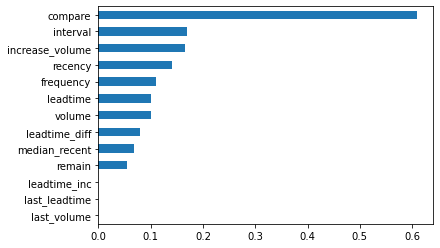

In [1520]:
imp_cat = Series(mutual_info_classif(X_train, y_train),
                 index = X_train.columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [1231]:
train_features_x = train_features[feature_list]

## Training 

Важным элементом решения задачи является разбитие данных. 

Данные разбиваются последовательно на обучающую и валидационные выборки. Но здесь еще стоит обратить внимание, что мы ищем категории, которые будут покупаться в следующую неделю за обучающей и соответственно валидационной выборкой. Для категорий, которые семья покупала, присвоим значение 1, если нет, то 0.

Поскольку мы имеем дело с меняющимся таймфремом, эту процедуру применим для нескольких выборок. А обучение будет проходить внутри цикла. Посчитаем среднее.

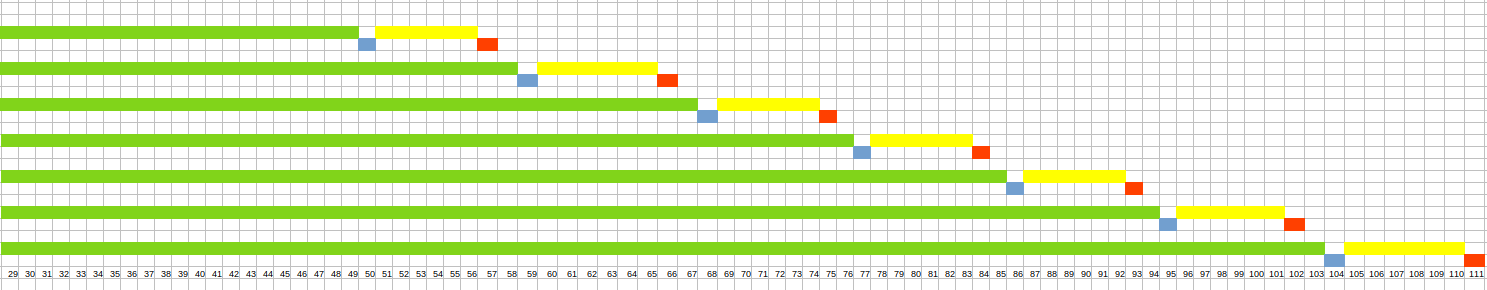

In [1409]:
# Данные разобъем вручную:
train_1 = data_order_cat[data_order_cat.week <= 35]
val_1 = data_order_cat[(data_order_cat.week > 35)&(data_order_cat.week <= 42)]
train_2 = data_order_cat[data_order_cat.week <= 44]
val_2 = data_order_cat[(data_order_cat.week > 44)&(data_order_cat.week <= 51)]
train_3 = data_order_cat[data_order_cat.week <= 53]
val_3 = data_order_cat[(data_order_cat.week > 53)&(data_order_cat.week <= 60)]
train_4 = data_order_cat[data_order_cat.week <= 77]
val_4 = data_order_cat[(data_order_cat.week > 77)&(data_order_cat.week <= 84)]
train_5 = data_order_cat[data_order_cat.week <= 86]
val_5 = data_order_cat[(data_order_cat.week > 86)&(data_order_cat.week <= 93)]
train_6 = data_order_cat[data_order_cat.week <= 104]
val_6 = data_order_cat[(data_order_cat.week > 104)&(data_order_cat.week <= 111)]

###  Тестируем различные модели

In [1425]:
log_reg_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    log_reg = LogisticRegression(C=0.0001,
                                 random_state = 42,
                                 penalty='l2',
                                 max_iter=200, 
                                 class_weight='balanced',
#                                  solver='saga',
                                 solver='liblinear' 
                                )
    log_reg.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = log_reg.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    log_reg_score.append(f1)
    
average_f1 = np.mean(log_reg_score)
print(average_f1)

0.6217164643635232


In [1445]:
bagging_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    clf = LogisticRegression(C=0.0001,random_state = 42,
                                 penalty='l2',
                                 max_iter=200, 
                                 class_weight='balanced',
                                 solver='liblinear')

    bagging = BaggingClassifier(clf, n_estimators=50, random_state=42, n_jobs=-1, oob_score=True)
    
    
    bagging.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = bagging.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    bagging_score.append(f1)
    
average_f1 = np.mean(bagging_score)
print(average_f1)

0.6290829375228353


In [1513]:
xgb_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    xgb = XGBClassifier(objective ='reg:squarederror',
                        random_state = 42,
                        colsample_bytree = 0.01, 
                        learning_rate = 0.0001, 
                        use_label_encoder=False, 
                        scale_pos_weight=2,
                        max_depth = 5, 
                        alpha = 1, 
                        n_estimators = 80, 
                        eval_metric='mlogloss')
                                         
    xgb.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = xgb.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    xgb_score.append(f1)
    
average_f1 = np.mean(xgb_score)
print(average_f1)

0.489057239057239


In [1412]:
cat_boost_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    cat_boost = CatBoostClassifier(verbose=False,
#                                    iterations = 300,
                                   n_estimators = 900,
                                   l2_leaf_reg= 2,
                                   min_data_in_leaf = 4,
                                   depth=8,
                                   learning_rate = 0.5,
                                   random_seed = 42,
                                  )
    
    cat_boost.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = cat_boost.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    cat_boost_score.append(f1)
    
average_f1 = np.mean(cat_boost_score)
print(average_f1)

0.4312146187146187


In [1438]:
x_tree_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    
    x_tree = ExtraTreesClassifier(random_state=42, 
                                 max_depth=9,
                                 n_estimators = 100,
                                 class_weight='balanced_subsample',
                                 min_samples_split = 6,
                                 max_features='auto' )
    
    x_tree.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = x_tree.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    x_tree_score.append(f1)
    
average_f1 = np.mean(x_tree_score)
print(average_f1)

0.41636141636141627


In [1468]:
forest_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    forest = RandomForestClassifier(n_estimators=900,
                                    random_state = 42,
                                    n_jobs=-1,
                                    max_features=8,
                                    max_depth=8,
                                    class_weight='balanced_subsample',
                                    ccp_alpha=0.07)
    
    forest.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = forest.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    forest_score.append(f1)
    
average_f1 = np.mean(forest_score)
print(average_f1)

0.4166666666666667
